# Malaria Project - Implementation
## Detecting Malaria cells using CNN and TF 2.0


### By:
- Lukas Wagner s0556753
- Laila Westphal s0556469


## Table of Contents:
* [Introduction](#Introduction)
* [Brief discussion about existing kernels](#Brief-discussion-about-existing-kernels)
  * [Kernel 1](#Kernel-1:-Detecting-Malaria-cells-using-Convolutional-Neural-Network)
  * Kernel 2
* [Getting Started](#Getting-Started) 
  * [Imports](#Imports)
  * [Load Data](#LoadData)
* [Preprocess Data](#Preprocess-Data)
  * [Feature Engineering](#Feature-Engineering)
  * [Data Augmentation](#Data-Augmentation)
  * [Visualizing Augmented Data](#Visualizing-Augmented-Data)
  * [Generate Data and Labels](#Generate-all-Data-and-Labels)
  * [Save/Load Data](#Save/Load-Data)
  * Split Data
* Data-Visualization
* Setup CNN
* Train data
* Evaluate?
* Predictions using test data
* Visualize Accuracy
* Results, Confusion Matrix
* Visualize Results
* Licenses
* Acknowledgements


# Introduction

# Brief discussion about existing kernels

In this section two kernels from the kaggle website dealing with the malaria dataset will be analized regarding data augmentation, data-split, cnn-architecture, used activation functions and obtained results (accuracy ...).
They are being used as a guideline for our own implementation.

## Kernel 1: Detecting Malaria cells using Convolutional Neural Network
### By: Kushal Mahindrakar
Source:https://www.kaggle.com/kushal1996/detecting-malaria-cnn

#### Data Augmentation:
- Done using the Python Image Libary (PIL) that provides support for opening, editing and saving many different data formats
- The quantity of the "Parasitized" data is being quadrupled.
- The quantity of the "Uninfected" data is being tripled.

#### Data-Split
The data in this kernel is being split into training, evaluation and test data:
   - training-data: 80%
   - evaluation-data: 10%
   - test-data: 10%

#### Used CNN-Architecture and activation functions:

| Layer-Type   | Units | Nb_Filters | KernelSize PoolSize | Padding | Activation | Stride |
|--------------|-------|------------|---------------------|---------|------------|--------|
| Input        | _     | _          | _                   | _       | _          | _      |
|  Conv        | _     | 50         | 7x7                 | same    | ReLU       | _      |
| Conv         | _     | 90         | 3x3                 | valid   | ReLU       | _      |
| Conv         | _     | 10         | 5x5                 | same    | ReLU       | _      |
| Pool         | _     | _          | 2x2                 | _       | _          | 2      |
| Conv         | _     | 5          | 3x3                 | same    | ReLU       | _      |
| Pool         | _     | _          | 2x2                 | same    | _          | 2      |
| Pool_flatten | _     | _          | _                   | _       | _          | _      |
| FC           | 2000  | _          | _                   | _       | ReLU       | _      |
| FC           | 1000  | _          | _                   | _       | ReLU       | _      |
| FC           | 500   | _          | _                   | _       | ReLU       | _      |
| Logits       | 2     | _          | _                   | _       | _          | _      |

#### Obtained Results:

| _           | precision |   recall | f1-score |  support |
|-------------|-----------|----------|----------|----------|
|           0 |      0.90 |     0.93 |     0.91 |     4223 |
|           1 |      0.95 |     0.92 |     0.93 |     5423 |
|_            | _         | _        | _        | _        |
|   micro avg |      0.92 |     0.92 |     0.92 |     9646 |
|   macro avg |      0.92 |     0.92 |     0.92 |     9646 |
|weighted avg |      0.92 |     0.92 |     0.92 |     9646 |
| _           | _         | _        | _        | _        |
|0.9238026124818578



## Kernel 2:
suggestion: https://www.kaggle.com/sharp1/malaria-cells-classification-through-keras

# Getting Started

## Imports

In [234]:
# Uncomment to install TF 2.0 if you don't have it
#!pip install tensorflow==2.0.0-beta1

In [235]:
# INCLUDE DOWNLOAD POSSIBILITY FOR DATA

In [236]:
# linear algebra
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
# computer vision library, image processing
import cv2
# used for data augmentation
from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter
# to use operating system dependent functionality
import os

## Load Data

In [237]:
# Loads data by classes/categories (e.g Parasitized, Uninfected)
def loadData(path):
        "__________________________________________"
        "    Args:"
        "        path: path to your data"
        "    return: Dict((class, label): list<data>)"
        "__________________________________________"

        clazzes = os.listdir(path)
        clazz_data = dict()
        for clazz, label in zip(clazzes, range(len(clazzes))):
            clazz_data.update({(clazz, label) : (os.listdir(path + "/" + clazz))})
        return clazz_data
        

In [238]:
# Check whether you obtained the right results
check_data = loadData("data/cell_images")
print(check_data.keys())
for clazz in check_data:
    print(clazz[0] + " " + str(clazz[1]) + ": " + str(len(check_data.get(clazz))))

dict_keys([('Parasitized', 0), ('Uninfected', 1)])
Parasitized 0: 13780
Uninfected 1: 13780


# Preprocess Data

In this section the data will be preprocessed in order to fulfil the requirements we have:
- feature engineering: here we will eliminate files that are no images (e.g. my Uninfected and Parasitized folders both contain a temp file which we don'T need and that would cause the program to fail)
- resize the image to be of the input size we want to use
- mode: decide on RGB, Greyscale...

## Feature Engineering

In [239]:
def preprocessData(image_path, h_img, w_img, mode='RGB'):
    "__________________________________________"
    "    Args:"
    "       image_path: image path"
    "       h_img: new height of image
    "       w_img: new idth of image
    "       mode='RGB"
    "    return: preprocessed image"
    "__________________________________________"
    image = cv2.imread(image_path)
    if image is None:
        return None
    img_as_array = Image.fromarray(image, mode)
    preprocessed_img = img_as_array.resize((h_img,w_img))
    return preprocessed_img
    

## Data Augmentation
- form of regularization
- useful for cells because impossible to predict position they will have
--> find source

In [240]:
def augmentData(image, label, rotations=None, mirror=False, blur=False):
    img_data = []
    img_labels = []
    if rotations:
        for rot in rotations:
            im = image.rotate(rot)
            img_data.append(np.array(im))
            img_labels.append(label)
    if mirror:
        #for mi in mirror:
            #im = image.transpose(Image.mirror)
        im = ImageOps.mirror(image)
        #img_data.append(np.array(im))
        img_data.append(np.array(im))
        img_labels.append(label)
    if blur:
        im = image.filter(ImageFilter.BLUR)
        img_data.append(np.array(im))
        img_labels.append(label)
    return img_data, img_labels
        
    

## Visualizing Augmented Data

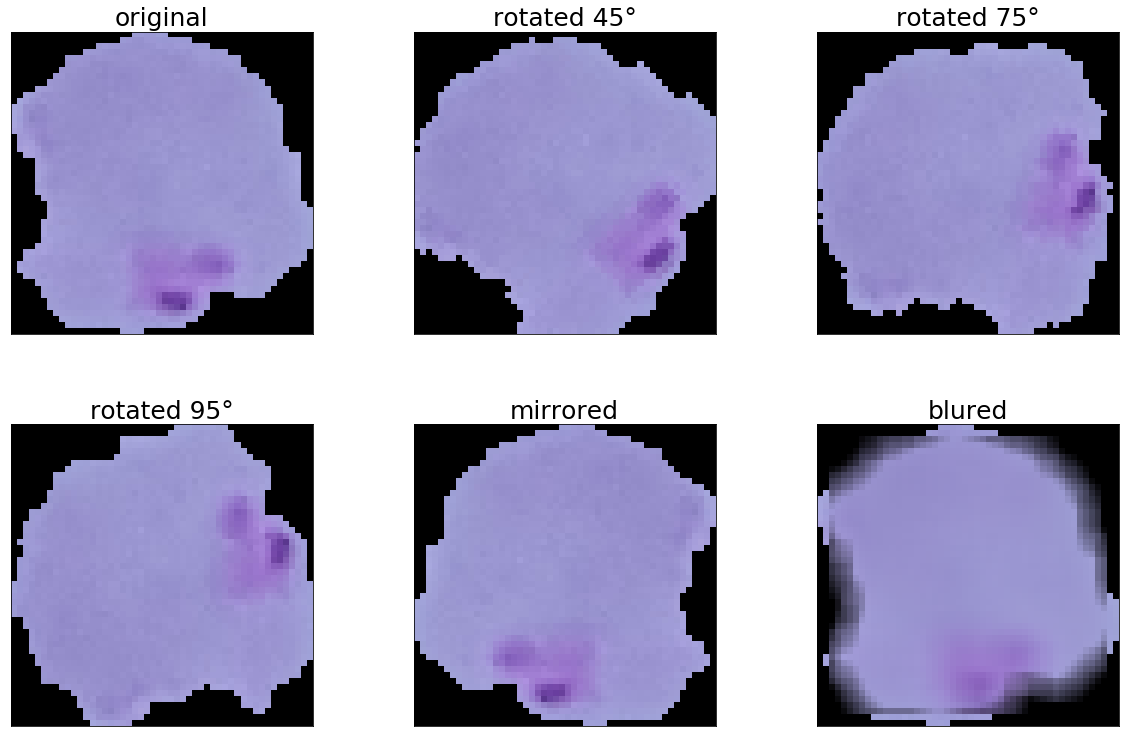

In [267]:
image = preprocessData("data/cell_images/Parasitized/C99P60ThinF_IMG_20150918_141520_cell_107.png", 50,50)
augmented, augl = augmentData(image, 0 ,rotations=[45,75,95], mirror = True, blur = True)
images = []
images.append(np.array(image))
images.extend(augmented)
#print(len(images))
titles = ["original", "rotated 45°", "rotated 75°", "rotated 95°", "mirrored", "blured"]
plt.figure(1, figsize=(20,20))
n = 0
for img in images:
    n += 1
    plt.subplot(3,3,n)
    plt.subplots_adjust(hspace=0.3, wspace= 0.3)
    plt.imshow(img)
    plt.title(titles[n-1], fontsize=25)
    plt.xticks([]), plt.yticks([])

plt.show()

# Generate all Data and Labels

In [ ]:
def generateData(path, h_img, w_img, mode='RGB', rotations=None, mirror=False, blur=False):
    data = []
    labels = []
    clazz_data = loadData(path)
    for clazz in clazz_data:
        for img in clazz_data.get(clazz):
            img_path = path + "/" + clazz[0] + "/" + img
            print(img_path)
            prep_img = preprocessData(img_path, h_img, w_img)
            #print(np.array(prep_img).shape)
            if prep_img is None:
                continue
            data.append(np.array(prep_img))
            labels.append(clazz[1])
            augm_data, augm_label = augmentData(prep_img,clazz[1], rotations, mirror, blur)
            data.extend(augm_data)
            labels.extend(augm_label)
    return data, labels
        
    

In [ ]:
#checking whether data and label genration work properly
data, labels = generateData("data/cell_images", 50, 50, rotations=[45,75], blur = True)

#There should be 110232 images in total
print('Number of data: {} \nNumber of labels: {}'.format(len(d), len(l)))

# There should be 55116 images for each class
print('Expecting labels to be 0 : l[55114] = {}, l[55115] = {} \nExpecting labels to be 1 : l[55116] = {}, l[55117] = {}'.format(l[55114],l[55115],l[55116],l[55117]))

## Save/Load Data

In [273]:
cells = np.array(data)                 
labelz = np.array(labels)
print(cells.shape)
print(labelz.shape)
np.save('cell_data', cells)
np.save('cell_labels', labelz)


# from: https://www.kaggle.com/sharp1/malaria-cells-classification-through-keras
#Cells=np.load("Cells.npy")
#labels=np.load("labels.npy")



(110232, 50, 50, 3)
(110232,)


## Split Data

In [275]:
# shuffle data

# Return evenly spaced values within a given interval(Here: 0-110231)
# For integer arguments the function is equivalent to the Python built-in range function, but returns an
# ndarray rather than a list.
r = np.arange(cells.shape[0])

# shuffles all the values in r
np.random.shuffle(r)
# rearanges/shuffles order of cells
cells = cells[r]
# rearanges/shuffles order of labels
labelz = labelz[r]


In [278]:
# Copy of the array, cast to a specified type.
cells = cells.astype(np.float32)
labelz = labelz.astype(np.int32)
# Pixel values of cells range from 0 to 255
# To scale them to range from 0 to 1 -> divide by 255
#cells = cells/255.0

MemoryError: 

## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

Malaria Project - Implementation<br/>
Detecting Malaria cells using CNN and TF 2.0 <br/>
by Lukas Wagner, Laila Westphal <br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2019 Lukas Wagner, Laila Westphal

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Acknowledgements

